In [3]:
import torchvision
import numpy as np
import timm
import detectors
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import torch
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import entropy

/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# define the transformation for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# Pick only the first 1000 samples so that my laptop can run it in a reasonable time
dataset = Subset(dataset, np.arange(1000))

dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

# Load pre-trained SimCLR ResNet50 model
model = timm.create_model("resnet50_simclr_cifar10", pretrained=True)

In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT feature extractor and model
model_name = "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
improved_model = ViTModel.from_pretrained(model_name).to(device)

# Define transformation (using ViT feature extractor normalization)
transform_improved = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load CIFAR-10 dataset
dataset_improved = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform_improved, download=True)

# Pick only the first 1000 samples to reduce memory usage
dataset_improved = Subset(dataset_improved, np.arange(1000))
dataloader_improved = DataLoader(dataset_improved, batch_size=128, shuffle=False, num_workers=2)

/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at aaraki/vit-base-patch16-224-in21k-finetuned-cifar10 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def typiclust(unlabeled_loader, model, budget, labeled_indices=None):
    model.eval()
    penultimate_features = []
    labels = []

    # Generates the embeddings for each image
    with torch.no_grad():
        for images, targets in unlabeled_loader:
            if isinstance(images, list):
                images = torch.stack(images)
            images = images.to(next(model.parameters()).device)       

            # Extract penultimate features
            modules = list(model.children())[:-1]
            backbone = torch.nn.Sequential(*modules)
            feats = backbone(images)
            labels.append(targets.numpy())

            penultimate_features.append(feats.cpu().numpy())

    # Concatenate features
    features = np.concatenate(penultimate_features, axis=0)
    labels = np.concatenate(labels, axis=0)

    penultimate_features = np.vstack(penultimate_features)

    # Optimize K-Means Clustering
    labeled_count = len(labeled_indices) if labeled_indices is not None else 0
    n_clusters = max(budget, labeled_count + budget)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(penultimate_features)

    # Initialise typicality score array
    typicality_scores = np.zeros(len(penultimate_features))

    # Loops over each cluster to compute typicality
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) == 0:
            continue

        cluster_points = penultimate_features[cluster_indices]
        k_neighbors = 20

        # Ensure k_neighbors is valid
        k_neighbors = min(k_neighbors, len(cluster_points) - 1)

        # Compute Nearest Neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='auto').fit(cluster_points)
        distances, _ = nbrs.kneighbors(cluster_points)

        # Compute inverse mean distance for typicality
        mean_distances = distances[:, 1:].mean(axis=1)  # Exclude self-distance
        typicality_scores[cluster_indices] = 1.0 / (mean_distances + 1e-9)

    # Select the most typical examples from the largest uncovered clusters
    uncovered_clusters = set(range(n_clusters))
    if labeled_indices is not None:
        labeled_clusters = set(cluster_labels[idx] for idx in labeled_indices)
        uncovered_clusters -= labeled_clusters

    uncovered_clusters = sorted(uncovered_clusters, key=lambda c: np.sum(cluster_labels == c), reverse=True)
    selected_clusters = uncovered_clusters[:budget]

    selected_indices = []
    for c in selected_clusters:
        cluster_idx = np.where(cluster_labels == c)[0]
        if labeled_indices is not None:
            cluster_idx = [idx for idx in cluster_idx if idx not in labeled_indices]
        if len(cluster_idx) == 0:
            continue

        # Pick the most typical point in each selected cluster
        best_idx = cluster_idx[np.argmax(typicality_scores[cluster_idx])]
        selected_indices.append(best_idx)

    selected_indices = selected_indices[:budget]  # Ensure exact budget size

    return features, labels, selected_indices, cluster_labels

In [7]:
def typiclust_improved(unlabeled_loader, model, budget, labeled_indices=None):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    features = []
    labels = []

    with torch.no_grad():
        for images, targets in unlabeled_loader:
            images = images.to(device)

            # Determine if the model is a Vision Transformer (ViT) or CNN (ResNet)
            outputs = model(images)

            if hasattr(outputs, "last_hidden_state"):  # If the model is a ViT
                features.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())  # Extract CLS token
            else:  # If it's a CNN (e.g., ResNet, EfficientNet)
                features.append(outputs.cpu().numpy())  # Use the direct feature output

            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Clustering with K-Means
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(features)

    # Compute Typicality Scores
    typicality_scores = np.zeros(len(features))

    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) == 0:
            continue

        cluster_points = features[cluster_indices]
        k_neighbors = min(20, len(cluster_points) - 1)
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm="auto").fit(cluster_points)
        distances, _ = nbrs.kneighbors(cluster_points)

        mean_distances = distances[:, 1:].mean(axis=1) if distances.shape[1] > 1 else np.zeros(len(distances))
        typicality_scores[cluster_indices] = 1.0 / (mean_distances + 1e-9)

    # Select the most typical examples
    uncovered_clusters = sorted(range(n_clusters), key=lambda c: np.sum(cluster_labels == c), reverse=True)
    selected_indices = []

    while len(selected_indices) < budget:
        for c in uncovered_clusters:
            if len(selected_indices) >= budget:
                break

            cluster_idx = np.where(cluster_labels == c)[0]
            if labeled_indices is not None:
                cluster_idx = [idx for idx in cluster_idx if idx not in labeled_indices and idx not in selected_indices]

            if len(cluster_idx) == 0:
                continue

            best_idx = cluster_idx[np.argmax(typicality_scores[cluster_idx])]
            selected_indices.append(best_idx)

    if len(selected_indices) < budget:
        print(f"⚠️ Warning: Only {len(selected_indices)} samples selected out of {budget}.")

    return features, labels, selected_indices, cluster_labels

In [8]:
def plot_tsne(features, labels, selected_indices):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))

    # Scatter plot for all images (colored by class)
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1], 
        c=labels, cmap="tab10", alpha=0.7, edgecolors="none"
    )

    # Highlight selected images as black 'x' markers
    plt.scatter(
        reduced_features[selected_indices, 0], reduced_features[selected_indices, 1],
        c='black', marker='x', s=100, label="Selected Images"
    )

    # Legend and Labels
    plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    plt.legend(loc="upper left")
    plt.title("t-SNE Visualisation of Embeddings (Selected Images Highlighted)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [9]:
def plot_class_diversity(dataset, selected_indices):
    """Plots class diversity for selected samples."""
    from collections import Counter
    import matplotlib.pyplot as plt
    import numpy as np

    # Debug: Print first few selected indices
    print("First few selected indices:", selected_indices[:10])

    # Extract only the class labels from dataset
    selected_classes = [dataset[idx][1] for idx in selected_indices]  # ✅ Access label correctly

    # Debug: Print class distribution
    print("Selected Classes Count:", Counter(selected_classes))

    # Count occurrences of each class
    selected_counts = Counter(selected_classes)

    # Convert counts to ordered lists
    all_classes = list(range(10))
    selected_freq = [selected_counts.get(cls, 0) for cls in all_classes]

    # Debug: Print class frequency
    print("Class Frequency:", selected_freq)

    # Create the bar chart
    plt.figure(figsize=(5, 5))
    plt.bar(np.arange(len(all_classes)), selected_freq, color="blue", label="TPC_RP Selection")

    # Labels and formatting
    plt.xticks(ticks=np.arange(len(all_classes)), labels=all_classes)
    plt.legend()
    plt.xlabel("Class")
    plt.ylabel("Number of Images Selected")
    plt.title("Class Diversity: TPC_RP")
    plt.show()

# Example Call (Pass the dataset, not labels)
# plot_class_diversity(full_dataset, typiclust_selected_indices)

In [10]:
def evaluate_clustering(labels, cluster_labels):
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    ari = adjusted_rand_score(labels, cluster_labels)
    
    print(f"✅ Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"✅ Adjusted Rand Index (ARI): {ari:.4f}")
    
    return {"NMI": nmi, "ARI": ari}


def compute_class_diversity(labels, selected_indices, num_classes=10):
    # Extract selected class labels from indices
    selected_classes = np.array([labels[idx] for idx in selected_indices])

    # Count occurrences of each class
    class_counts = np.bincount(selected_classes, minlength=num_classes)

    # Convert counts to probabilities
    probs = class_counts / class_counts.sum()

    # Compute entropy (ignore zero probabilities to avoid log(0))
    diversity_score = entropy(probs, base=2)

    # Normalize by max entropy log2(num_classes)
    max_entropy = np.log2(num_classes)
    normalized_diversity_score = diversity_score / max_entropy if max_entropy > 0 else 0

    return normalized_diversity_score  # Now guaranteed to be between 0 and 1

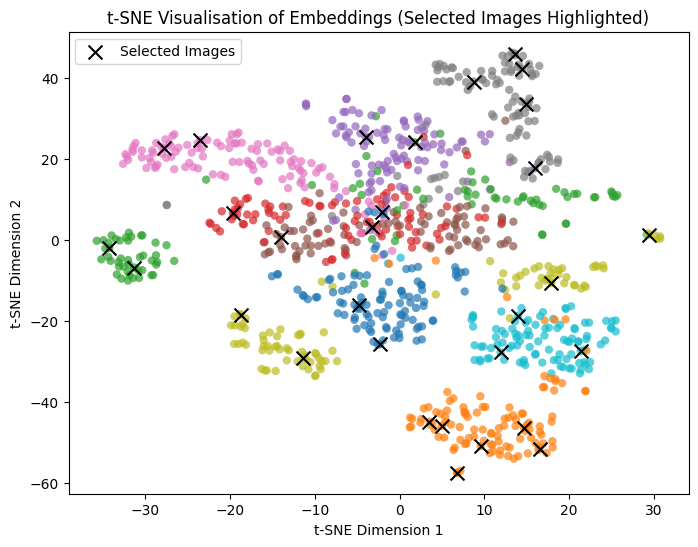

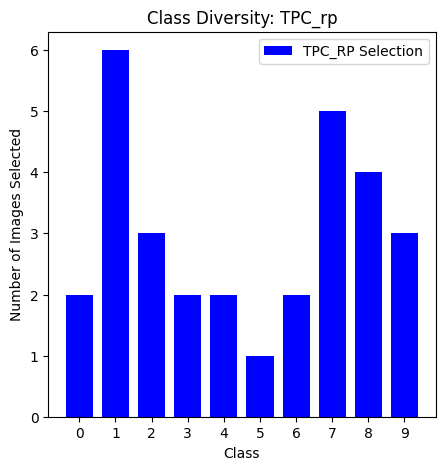

In [ ]:
features, labels, selected_indices, cluster_labels = typiclust(train_dataloader, model, 30)
plot_tsne(features, labels, selected_indices)
plot_class_diversity(labels, selected_indices)

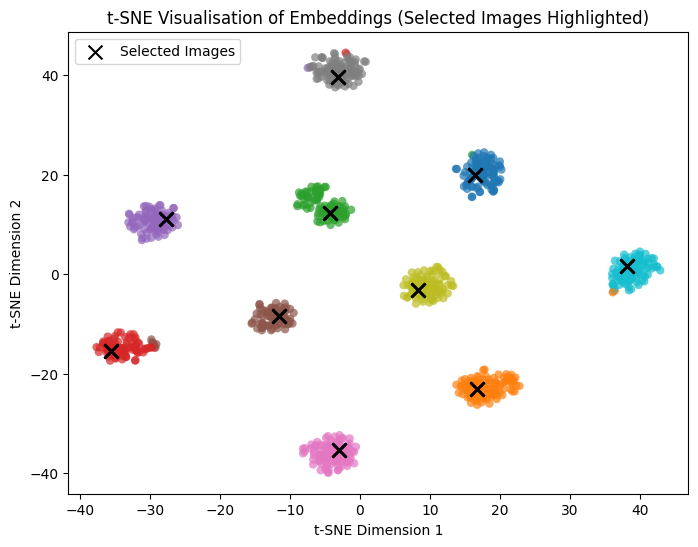

In [11]:
improved_features, improved_labels, improved_selected_indices, improved_cluster_labels = typiclust_improved(dataloader_improved, improved_model, 100)
plot_tsne(improved_features, improved_labels, improved_selected_indices)

First few selected indices: [np.int64(942), np.int64(619), np.int64(1), np.int64(595), np.int64(199), np.int64(971), np.int64(343), np.int64(957), np.int64(445), np.int64(515)]
Selected Classes Count: Counter({1: 10, 6: 10, 9: 10, 7: 10, 0: 10, 8: 10, 4: 10, 2: 10, 3: 10, 5: 10})
Class Frequency: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


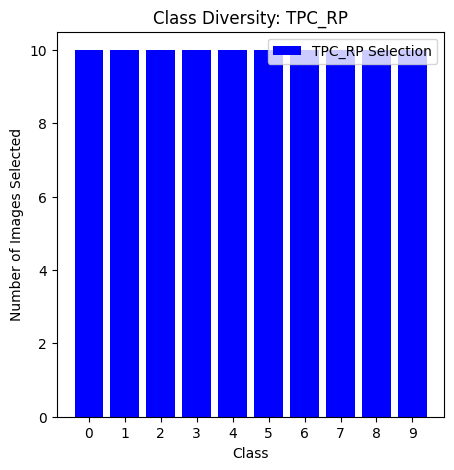

In [12]:
plot_class_diversity(dataset_improved, improved_selected_indices)

In [108]:
clustering_accuracy = evaluate_clustering(labels, cluster_labels)
improved_clustering_accuracy = evaluate_clustering(improved_labels, improved_cluster_labels)

diversity_score = compute_class_diversity(labels, selected_indices)
improved_diversity_score = compute_class_diversity(improved_labels, improved_selected_indices)

print(f"Diversity score: {diversity_score}, Improved diversity score: {improved_diversity_score}")

✅ Normalized Mutual Information (NMI): 0.5828
✅ Adjusted Rand Index (ARI): 0.2656
✅ Normalized Mutual Information (NMI): 0.9800
✅ Adjusted Rand Index (ARI): 0.9791
Diversity score: 0.9490224219555417, Improved diversity score: 1.0


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define Fully Supervised Classifier (ResNet18)
class FullySupervisedClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FullySupervisedClassifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Function to reinitialize model weights
def initialize_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Train Fully Supervised Classifier
def train_fully_supervised(train_loader, test_loader, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FullySupervisedClassifier().to(device)

    # Initialize Weights
    initialize_weights(model)

    # Optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        scheduler.step()

    return model

In [21]:
# Define Linear Classifier
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Function to train Linear Classifier on Embeddings
def train_linear_classifier(train_embeddings, train_labels, test_embeddings, test_labels, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = train_embeddings.shape[1]
    model = LinearClassifier(input_dim).to(device)
    optimizer = optim.SGD(model.parameters(), lr=2.5, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Convert data to tensors
    train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
    test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(train_embeddings)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

    return model

In [22]:
import torch.nn.functional as F

class FixMatchModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FixMatchModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

def train_semi_supervised(train_loader, unlabeled_loader, test_loader, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FixMatchModel().to(device)  # Ensure the model is defined properly

    optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for (labeled_data, labels), (unlabeled_data, _) in zip(train_loader, unlabeled_loader):
            labeled_data, labels = labeled_data.to(device), labels.to(device)
            unlabeled_data = unlabeled_data.to(device)

            # Weak augmentation
            weak_aug_data = labeled_data

            # Strong augmentation (RandAugment placeholder)
            strong_aug_data = unlabeled_data  # Replace with actual RandAugment

            # Compute outputs
            labeled_outputs = model(weak_aug_data)
            pseudo_labels = torch.softmax(model(strong_aug_data), dim=1)
            max_probs, pseudo_targets = torch.max(pseudo_labels, dim=1)

            # Apply confidence threshold
            mask = max_probs > 0.95

            # **🛠 FIX: Ensure we only compute loss if there are enough samples**
            if mask.sum() > 1:  # Ensures at least 2 samples in batch
                unsupervised_loss = F.cross_entropy(model(strong_aug_data[mask]), pseudo_targets[mask])
            else:
                unsupervised_loss = torch.tensor(0.0, device=device)  # Skip this step

            # Compute total loss
            supervised_loss = criterion(labeled_outputs, labels)
            loss = supervised_loss + unsupervised_loss

            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [17]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# ✅ Standard CIFAR-10 transform for ResNet & CNNs
cnn_transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard CIFAR-10 normalization
])

# ✅ Separate Transform for ViT (224x224 + Different Normalization)
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# ✅ Load CIFAR-10 dataset (only first 1000 samples for efficiency)
full_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=cnn_transform, download=True)

# ✅ Create a ViT-Compatible Dataset (using 224x224 transforms)
vit_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=vit_transform, download=True)

# ✅ Pick first 1000 samples for efficiency
subset_indices = np.arange(1000)
full_dataset = Subset(full_dataset, subset_indices)
vit_dataset = Subset(vit_dataset, subset_indices)  # Keep ViT dataset separate

# ✅ Split into 900 training samples and 100 test samples
train_indices, test_indices = subset_indices[:900], subset_indices[900:]
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# ✅ Separate Train/Test Dataset for ViT
train_vit_dataset = Subset(vit_dataset, train_indices)
test_vit_dataset = Subset(vit_dataset, test_indices)

# ✅ Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# ✅ ViT DataLoaders (224x224 images)
train_vit_dataloader = DataLoader(train_vit_dataset, batch_size=64, shuffle=False, num_workers=2)
test_vit_dataloader = DataLoader(test_vit_dataset, batch_size=64, shuffle=False, num_workers=2)

In [23]:
import random
from collections import defaultdict

def random_selection_per_class(dataset, budget_per_class=10):
    """Selects `budget_per_class` random samples per class."""
    class_indices = defaultdict(list)

    # Collect indices per class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, budget_per_class))

    return selected_indices  # Return **indices of randomly selected images**

In [24]:
import torch

def evaluate_classifier(model, test_loader):
    """Evaluates a trained classifier on a test dataset."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get highest probability class
            
            # Update accuracy counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  # Return accuracy


import torch.nn.functional as F

def evaluate_linear_classifier(model, test_embeddings, test_labels):
    """Evaluates a linear classifier using extracted embeddings."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert to Tensors
    test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(test_embeddings)  # Forward pass
        _, predicted = torch.max(outputs, 1)

    # Compute accuracy
    accuracy = (predicted == test_labels).sum().item() / len(test_labels)
    return accuracy

In [25]:
import random
from collections import defaultdict

def random_selection_per_class(dataset, budget_per_class=10):
    """Selects `budget_per_class` random samples per class."""
    class_indices = defaultdict(list)

    # Collect indices per class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, budget_per_class))  # Select 10 per class

    return selected_indices  # Return **indices of randomly selected images**

In [26]:
import torch
import numpy as np

def extract_embeddings(dataloader, model):
    """Extract embeddings from a model for a given dataloader."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            # Forward pass
            outputs = model(images)

            # If model is ViT, extract CLS token embedding
            if hasattr(outputs, "last_hidden_state"):
                features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            else:  # CNN case (ResNet, EfficientNet, etc.)
                features = outputs.cpu().numpy()

            embeddings.append(features)
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    return embeddings, labels

In [18]:
# Define the number of labeled samples per class
budget_per_class = 10
num_labeled_samples = budget_per_class * 10  # 10 classes × 10 samples each

# Run TypiClust-Improved to select samples
features, labels, typiclust_selected_indices, cluster_labels = typiclust_improved(train_vit_dataloader, improved_model, num_labeled_samples)

# Extract TypiClust-selected raw images from the original dataset
typiclust_selected_data = torch.stack([full_dataset[i][0] for i in typiclust_selected_indices])
typiclust_selected_labels = torch.tensor([full_dataset[i][1] for i in typiclust_selected_indices], dtype=torch.long)

# Convert to Dataset & DataLoader
typiclust_train_dataset = torch.utils.data.TensorDataset(typiclust_selected_data, typiclust_selected_labels)
typiclust_train_loader = DataLoader(typiclust_train_dataset, batch_size=32, shuffle=True)

In [27]:
# Select 10 random samples per class
random_selected_indices = random_selection_per_class(train_dataset, budget_per_class=10)

# Extract raw images and labels
random_selected_data = torch.stack([full_dataset[i][0] for i in random_selected_indices])
random_selected_labels = torch.tensor([full_dataset[i][1] for i in random_selected_indices], dtype=torch.long)

# Convert to Dataset & DataLoader
random_train_dataset = torch.utils.data.TensorDataset(random_selected_data, random_selected_labels)
random_train_loader = DataLoader(random_train_dataset, batch_size=32, shuffle=True)

First few selected indices: [np.int64(576), np.int64(1), np.int64(619), np.int64(595), np.int64(62), np.int64(598), np.int64(445), np.int64(120), np.int64(856), np.int64(515)]
Selected Classes Count: Counter({1: 10, 9: 10, 6: 10, 7: 10, 8: 10, 0: 10, 3: 10, 2: 10, 4: 10, 5: 10})
Class Frequency: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


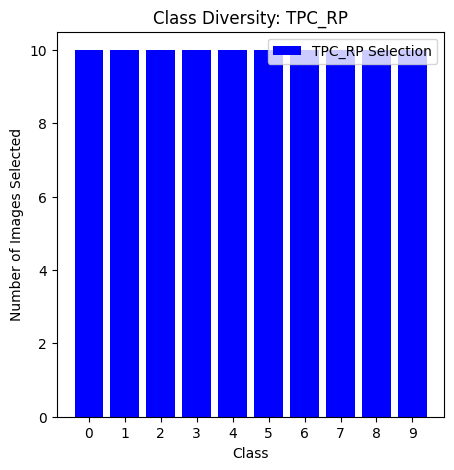

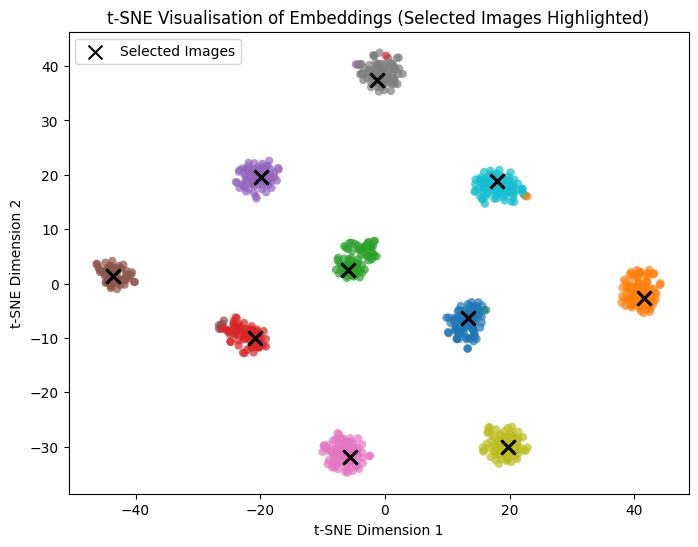

First few selected indices: [619, 437, 591, 645, 807, 23, 351, 625, 387, 728]
Selected Classes Count: Counter({6: 10, 9: 10, 4: 10, 1: 10, 2: 10, 7: 10, 8: 10, 3: 10, 5: 10, 0: 10})
Class Frequency: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


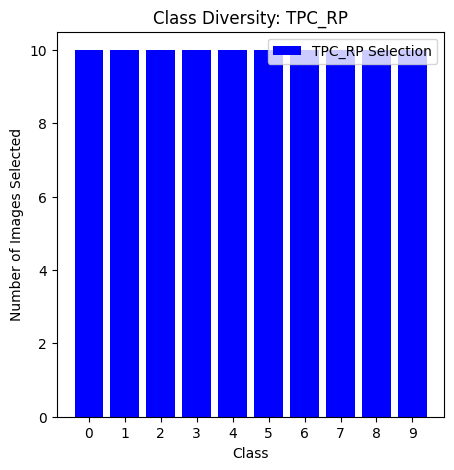

In [28]:
from collections import Counter

def check_class_distribution(selected_labels, selection_method):
    """Prints and verifies the class distribution of selected samples."""
    class_counts = Counter(selected_labels)
    print(f"\n{selection_method} Class Distribution: {dict(class_counts)}")

# Check TypiClust
plot_class_diversity(train_vit_dataset, typiclust_selected_indices)
plot_tsne(features, labels, typiclust_selected_indices)

# Check Random Selection
plot_class_diversity(train_dataset, random_selected_indices)

In [29]:
from collections import Counter

# Extract class distributions
improved_selected_classes = [improved_labels[idx] for idx in improved_selected_indices]
vit_selected_classes = [labels[idx] for idx in typiclust_selected_indices]

# Print class counts
print("Class Distribution (dataloader_improved):", Counter(improved_selected_classes))
print("Class Distribution (train_vit_dataloader):", Counter(vit_selected_classes))

Class Distribution (dataloader_improved): Counter({np.int64(1): 10, np.int64(6): 10, np.int64(9): 10, np.int64(7): 10, np.int64(0): 10, np.int64(8): 10, np.int64(4): 10, np.int64(2): 10, np.int64(3): 10, np.int64(5): 10})
Class Distribution (train_vit_dataloader): Counter({np.int64(1): 10, np.int64(9): 10, np.int64(6): 10, np.int64(7): 10, np.int64(8): 10, np.int64(0): 10, np.int64(3): 10, np.int64(2): 10, np.int64(4): 10, np.int64(5): 10})


In [30]:
# Extract embeddings for the test dataset
test_embeddings, test_labels = extract_embeddings(test_dataloader, model)

# Train ResNet18 model on TypiClust-selected samples
typiclust_supervised_model = train_fully_supervised(typiclust_train_loader, test_dataloader, num_epochs=50)

# Extract embeddings from TypiClust-selected samples
typiclust_train_embeddings, typiclust_train_labels = extract_embeddings(typiclust_train_loader, model)

# Train a Linear Classifier
typiclust_linear_model = train_linear_classifier(typiclust_train_embeddings, typiclust_train_labels, test_embeddings, test_labels, num_epochs=100)

# Create labeled dataset for TypiClust-selected samples
typiclust_labeled_loader = DataLoader(list(zip(typiclust_selected_data, typiclust_selected_labels)), batch_size=32, shuffle=True)

# Train Semi-Supervised Model (FlexMatch or FixMatch)
typiclust_semi_model = train_semi_supervised(typiclust_labeled_loader, train_dataloader, test_dataloader, num_epochs=50)

/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.D

In [33]:
# Train ResNet18 model on randomly-selected samples
random_supervised_model = train_fully_supervised(random_train_loader, test_dataloader, num_epochs=50)

# Extract embeddings from Randomly-selected samples
random_train_embeddings, random_train_labels = extract_embeddings(random_train_loader, model)

# Train a Linear Classifier
random_linear_model = train_linear_classifier(random_train_embeddings, random_train_labels, test_embeddings, test_labels, num_epochs=100)

# Create labeled dataset for Random-selected samples
random_labeled_loader = DataLoader(list(zip(random_selected_data, random_selected_labels)), batch_size=32, shuffle=True)

# Train Semi-Supervised Model (FlexMatch or FixMatch)
random_semi_model = train_semi_supervised(random_labeled_loader, train_dataloader, test_dataloader, num_epochs=50)

In [34]:
# Evaluate Fully Supervised Model
typiclust_supervised_acc = evaluate_classifier(typiclust_supervised_model, test_dataloader)

# ✅ FIX: Use the correct function for self-supervised models
typiclust_linear_acc = evaluate_linear_classifier(typiclust_linear_model, test_embeddings, test_labels)

# Evaluate Semi-Supervised Model
typiclust_semi_acc = evaluate_classifier(typiclust_semi_model, test_dataloader)

# Print results
print(f"Fully Supervised Accuracy: {typiclust_supervised_acc:.4f}")
print(f"Self-Supervised Accuracy: {typiclust_linear_acc:.4f}")
print(f"Semi-Supervised Accuracy: {typiclust_semi_acc:.4f}")

Fully Supervised Accuracy: 0.1000
Self-Supervised Accuracy: 0.7400
Semi-Supervised Accuracy: 0.1300


In [35]:
# Fully Supervised Accuracy
random_supervised_acc = evaluate_classifier(random_supervised_model, test_dataloader)

# Self-Supervised Accuracy
random_linear_acc = evaluate_linear_classifier(random_linear_model, test_embeddings, test_labels)

# Semi-Supervised Accuracy
random_semi_acc = evaluate_classifier(random_semi_model, test_dataloader)

# Print Results
print(f"Fully Supervised Accuracy - Random: {random_supervised_acc:.4f}")
print(f"Self-Supervised Accuracy - Random: {random_linear_acc:.4f}")
print(f"Semi-Supervised Accuracy - Random: {random_semi_acc:.4f}")

Fully Supervised Accuracy - Random: 0.1600
Self-Supervised Accuracy - Random: 0.8500
Semi-Supervised Accuracy - Random: 0.1100


In [69]:
print(len(typiclust_selected_indices))

100
